In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    LeakyReLU,
    Dropout,
    BatchNormalization,
    Flatten,
    Dense,
    Activation,
    Input,
    Reshape,
    Conv2DTranspose
)
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.0.0-beta1
GPU Available:  True


In [2]:
class WGAN():
    def __init__(self, dataset, lr=5e-5, c=0.01, m=64, n_critic=5, min_z=-1, max_z=1):
        # Config
        self.lr = lr
        self.c = c
        self.m = m
        self.n_critic = 5
        self.min_z = min_z
        self.max_z = max_z
        
        # Models
        self.C = self.critic()
        self.G = self.generator()
        
        # Data
        self.dataset = dataset
        self.data_iter = tf.compat.v1.data.make_one_shot_iterator(dataset)
        
        # Optimizers
        self.C_opt = tf.keras.optimizers.RMSprop(learning_rate=self.lr)
        self.G_opt = tf.keras.optimizers.RMSprop(learning_rate=self.lr)
        
    @tf.function
    def C_loss(self, C_real, C_fake):
        return tf.reduce_mean(C_real) - tf.reduce_mean(C_fake)
    
    @tf.function
    def G_loss(self, C_fake):
        return -tf.reduce_mean(C_fake)
    
    @tf.function
    def C_grad(self, real_inp, fake_inp):
        with tf.GradientTape() as tape:
            C_real = self.C(real_inp, training=True)
            C_fake = self.C(fake_inp, training=True)
            loss = self.C_loss(C_real, C_fake)
        return tape.gradient(loss, self.C.trainable_variables)
    
    @tf.function
    def G_grad(self, z):
        with tf.GradientTape() as C_tape, tf.GradientTape() as G_tape:
            fake = self.G(z, training=True)
            C_fake = self.C(fake, training=False)
            loss = self.G_loss(C_fake)
        return C_tape.gradient(loss, self.G.trainable_variables)
    
    def clip_weights(self):
        for l in self.C.layers:
            weights = l.get_weights()
            weights = [tf.clip_by_value(w, -self.c, self.c) for w in weights]
            l.set_weights(weights)
    
    @tf.function
    def C_train_on_batch(self):
        z = tf.random.uniform((self.m, 100,), self.min_z, self.max_z)
        fake_inp = self.G(z, training=False)
        real_inp = self.get_data_batch()
        grad = self.C_grad(real_inp, fake_inp)
        self.C_opt.apply_gradients(zip(grad, self.C.trainable_variables))
    
    @tf.function
    def G_train_on_batch(self):
        z = tf.random.uniform((self.m, 100,), self.min_z, self.max_z)
        grad = self.G_grad(z)
        self.G_opt.apply_gradients(zip(grad, self.G.trainable_variables))

    @tf.function
    def get_data_batch(self):
        return self.data_iter.get_next()
    
    def critic(self):
        dropout_prob = .4

        inputs = Input(shape=(32, 32, 3))

        # Input size = 32x32x3
        x = Conv2D(filters=128, kernel_size=5, padding='same', strides=(2, 2), input_shape=(32, 32, 3))(inputs)
        x = LeakyReLU(0.2)(x)
        # Output size = 16x16x128

        # Input size = 16x16x128
        x = Conv2D(filters=256, kernel_size=5, padding='same', strides=(2, 2))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        # Output size = 8x8x256

        # Input size = 8x8x256
        x = Conv2D(filters=512, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        # Output size = 4x4x512

        # Input size = 4x4x512
        x = Conv2D(filters=1024, kernel_size=5, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        # Output size = 4x4x1024

        # Input size = 4x4x1024
        x = Flatten()(x)
        out = Dense(1)(x)

        net = Model(inputs=inputs, outputs=out)

        return net
    
    def generator(self):
        dropout_prob = .4

        # Input size = 100
        inputs = Input(shape=(100,))
        x = Dense(4*4*1024, input_shape=(100,))(inputs)
        x = Reshape(target_shape=(4, 4, 1024))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 4x4x1024

        # Input size = 4x4x1024
        x = Conv2DTranspose(filters=512, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 8x8x512

        # Input size = 8x8x512
        x = Conv2DTranspose(filters=256, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 16x16x256

        # Input size = 16x16x256
        x = Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 32x32x128

        # Input size = 32x32x128
        x = Conv2DTranspose(filters=3, kernel_size=5, padding='same')(x)
        out = Activation('tanh')(x)
        # Output size = 32x32x3

        net = Model(inputs=inputs, outputs=out)

        return net
        

def critic():
        dropout_prob = .4

        inputs = Input(shape=(128, 128, 3))

        # Input size = 128x128x3
        x = Conv2D(filters=128, kernel_size=5, padding='same', input_shape=(128, 128, 3))(inputs)
        x = LeakyReLU(0.2)(x) # size = 64x64
        # Output size = 64x64x128

        # Input size = 64x64x128
        x = Conv2D(filters=256, kernel_size=5, padding='same', strides=(2, 2))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x) # size = 32x32
        # Output size = 32x32x256

        # Input size = 32x32x256
        x = Conv2D(filters=512, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x) # size = 16x16
        # Output size = 16x16x512

        # Input size = 16x16x512
        x = Conv2D(filters=1024, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x) # size = 8x8
        # Output size = 8x8x1024

        # Input size = 8x8x1024
        x = Flatten()(x)
        out = Dense(1)(x)

        net = Model(inputs=inputs, outputs=out)

        return net
    
    def generator():
        dropout_prob = .4

        # Input size = 100
        inputs = Input(shape=(100,))
        x = Dense(8*8*1024, input_shape=(100,))(inputs)
        x = Reshape(target_shape=(8, 8, 1024))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 8x8x1024

        # Input size = 8x8x1024
        x = Conv2DTranspose(filters=512, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 16x16x512

        # Input size = 16x16x512
        x = Conv2DTranspose(filters=256, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 32x32x256

        # Input size = 32x32x256
        x = Conv2DTranspose(filters=128, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(dropout_prob)(x)
        # Output size = 64x64x128

        # Input size = 64x64x128
        x = Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding='same')(x)
        out = Activation('tanh')(x)
        # Output size = 128x128x3

        net = Model(inputs=inputs, outputs=out)

        return net

In [3]:
(x_train, _), (_,_) = tf.keras.datasets.cifar10.load_data()

In [4]:
def preprocess_fn(image):
    x = tf.reshape(tf.cast(image, tf.float32), (32,32,3))
#     x /= 255
    x = 2*x/255 - 1 # convert image to [-1, 1] range
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

real_ds = tf.data.Dataset.from_tensor_slices(x_train)
real_ds = real_ds.shuffle(60000)
real_ds = real_ds.repeat()
real_ds = real_ds.apply(tf.data.experimental.map_and_batch(
        preprocess_fn, 64, num_parallel_batches=6, drop_remainder=True))
real_ds = real_ds.prefetch(tf.data.experimental.AUTOTUNE)

W0722 01:33:53.836092 13092 deprecation.py:323] From <ipython-input-4-52f28e52ec3f>:16: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [5]:
wgan = WGAN(real_ds)

In [ ]:
from IPython.display import clear_output, Image

for step in range(0, 15001):
    for i in range(0,5):
        wgan.C_train_on_batch()
        wgan.clip_weights()
    wgan.G_train_on_batch()
        
    if step % 50 == 0:
        clear_output(wait=True)
    print(f"Step: {step}")

Step: 50
Step: 51


(5, 32, 32, 3)


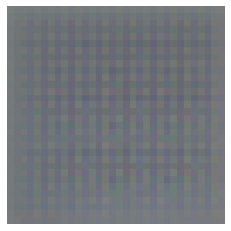

In [177]:
import numpy as np
import random
import matplotlib.pyplot as plt
noise = np.random.uniform(-1.0, 1.0, size=(5,100,))
fake_batch = wgan.G(noise)
print(fake_batch.shape)

fig = plt.figure()
plt.axis('off')
fake_batch = (fake_batch + 1) / 2
plt.imshow((fake_batch[3]))